In [43]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

Data RH Preparation

In [44]:
# Total tp preparation
# Load CSV
df_csv = pd.read_csv('/Users/Jia/Downloads/data_skripsi/kelembaban/rh_arrange.csv')

In [45]:
# Mengonversi kolom 'time' ke tipe data datetime
df_csv['time'] = pd.to_datetime(df_csv['time'])

# Menambahkan kolom 'month'
df_csv['month'] = df_csv['time'].dt.month

# Menambahkan kolom 'year'
df_csv['year'] = df_csv['time'].dt.year

# Melakukan group by bulan, longitude, dan latitude, dan menghitung rata-rata rh
rh_mean_monthly = df_csv.groupby(['month', 'year', 'longitude', 'latitude'], as_index=False)['rh'].mean()

In [46]:
print(df_csv.columns)

Index(['time', 'latitude', 'longitude', 'd2m', 't2m', 'rh', 'month', 'year'], dtype='object')


Optional

Menyimpan hasil ke file CSV #

df_csv.to_csv('/Users/Jia/Downloads/data_skripsi/kelembaban/rh_mean_month.csv', index=False)

Spatial Join df and gdf

In [47]:
# Load shapefile into a GeoDataFrame
gdf_shapefile = gpd.read_file(r"/Users/Jia/Downloads/data_skripsi/kota_DKIJakarta/Kota_DKIJakarta.shp")

In [48]:
# Convert DataFrame to GeoDataFrame
geometry = gpd.points_from_xy(df_csv['longitude'], df_csv['latitude'])
gdf_csv = gpd.GeoDataFrame(df_csv, geometry=geometry, crs="EPSG:4326")

<Axes: >

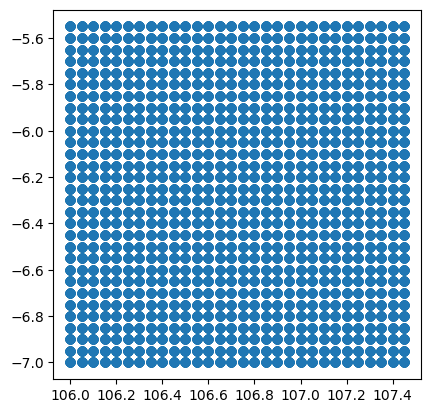

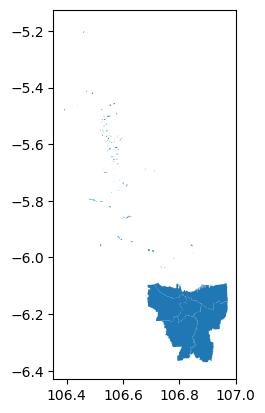

In [49]:
gdf_csv.plot()
gdf_shapefile.plot()

In [50]:
# spatial join
result = gpd.sjoin(gdf_csv, gdf_shapefile, how='inner', predicate='intersects')
result_pop = result[['longitude', 'latitude', 'rh', 'month', 'year', 'KABKOT', 'geometry', 'time']]

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1440 entries, 406 to 53659
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   longitude  1440 non-null   float64       
 1   latitude   1440 non-null   float64       
 2   rh         1440 non-null   float64       
 3   month      1440 non-null   int32         
 4   year       1440 non-null   int32         
 5   KABKOT     1440 non-null   object        
 6   geometry   1440 non-null   geometry      
 7   time       1440 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), geometry(1), int32(2), object(1)
memory usage: 90.0+ KB


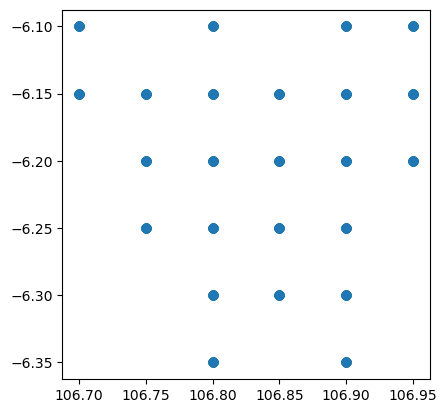

In [51]:
result_pop.plot()
result_pop.info()

Dissolved Result

In [52]:
# Dissolve berdasarkan 'KABKOT' dan 'month' dengan fungsi agregasi mean
dissolved_result = result_pop.dissolve(by=['KABKOT', 'month', 'year'], aggfunc='mean')

# Reset indeks untuk membuat kolom 'KABKOT' 'month', dan 'year' menjadi kolom
dissolved_result.reset_index(inplace=True)

In [53]:
# Tampilkan hasil
dissolved_result.head()

,KABKOT,month,year,geometry,longitude,latitude,rh,time
0,JAKARTA BARAT,1,2018,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,81.914160,2018-01-01
1,JAKARTA BARAT,1,2019,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,83.683022,2019-01-01
2,JAKARTA BARAT,1,2020,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,85.895006,2020-01-01
3,JAKARTA BARAT,1,2021,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,85.869056,2021-01-01
4,JAKARTA BARAT,1,2022,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,83.321066,2022-01-01


In [54]:
dissolved_result_df = pd.DataFrame(dissolved_result)
dissolved_result_df = dissolved_result_df.drop(['geometry'], axis=1) #kolom geometry di hapus

In [55]:
#untuk mengurutkan file berdasarkan
dissolved_result_df = dissolved_result_df.sort_values(by=[ 'year', 'KABKOT', 'month'])

In [56]:
dissolved_result_df.to_csv("/Users/Jia/Downloads/data_skripsi/kelembaban/dissolved_result_rh.csv") 

#di save ke csv, jadi data rata" bulanan

In [57]:
polygon_result = gpd.sjoin(gdf_shapefile, dissolved_result, how='inner', predicate='intersects')
polygon_result.rename(columns= {'KABKOT_left':'KABKOT', 'index_right':'index'}, inplace=True)
polygon_result.drop(columns={'KABKOT_right'}, inplace=True)

In [58]:
print(polygon_result.columns)

Index(['PROVNO', 'KABKOTNO', 'PROVINSI', 'KABKOT', 'geometry', 'index',
       'month', 'year', 'longitude', 'latitude', 'rh', 'time'],
      dtype='object')


Grafik Timetrend Series

In [59]:
import calendar

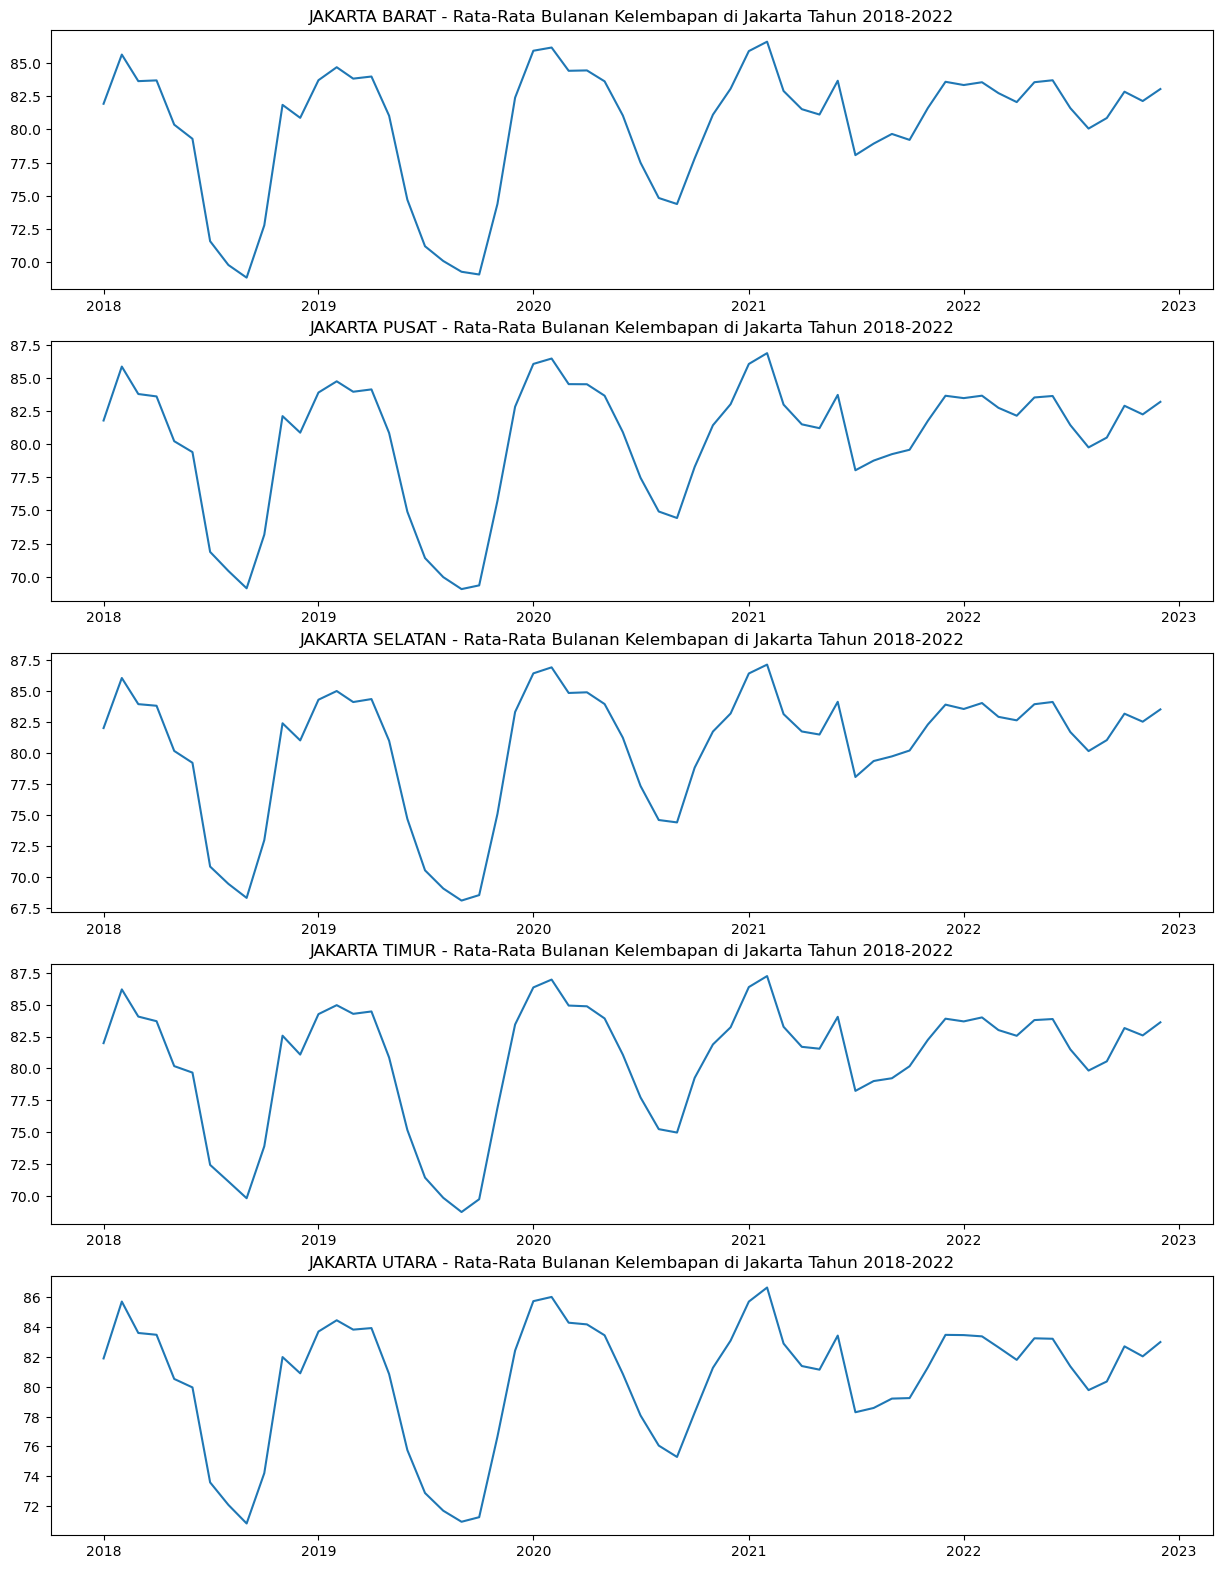

In [60]:
fig  = plt.figure(figsize=(15,60))
cities = list(dissolved_result_df['KABKOT'].unique())
dissolved_result_df = dissolved_result_df.set_index('time')

# Iterate through each month and plot the data
for city, ax in zip(cities, range(1,6)):
    # Filter data for the current wilayah admin
    data_city = dissolved_result_df[dissolved_result_df['KABKOT'] == city]

    # Plot the map for the current kabkot
    fig.add_subplot(15, 1, ax)
    plt.plot(data_city['rh'])
    plt.title(f'{city} - Rata-Rata Bulanan Kelembapan di Jakarta Tahun 2018-2022')
    #ax.set_title(f'{city}')

Analisis Univariat

In [61]:
mean_rh_month_year = dissolved_result.groupby(['year', 'month'], as_index=False)['rh'].mean()

mean_rh_month_year['rh'] = mean_rh_month_year['rh'].round(2)

mean_rh_month_year

,year,month,rh
0,2018,1,81.92
1,2018,2,85.88
2,2018,3,83.80
3,2018,4,83.65
4,2018,5,80.29
5,2018,6,79.51
6,2018,7,72.07
7,2018,8,70.58
8,2018,9,69.39
9,2018,10,73.41


In [62]:
#mean_rh_month_year.to_excel("/Users/Jia/Downloads/data_skripsi/kelembaban/rh_year_mean.xlsx")

In [72]:
# mean per tahun
rh_year_mean = dissolved_result.groupby(['year'], as_index=False)['rh'].mean()

rh_year_mean['rh'] = rh_year_mean['rh'].round(2)

rh_year_mean

,year,rh
0,2018,78.64
1,2019,77.66
2,2020,81.42
3,2021,82.03
4,2022,82.52


In [64]:
#nilai mean
rh_mean_5years = mean_rh_month_year ['rh'].mean()
rh_mean_5years

80.45266666666666

In [65]:
#nilai min
rh_min_5years = mean_rh_month_year ['rh'].min()
rh_min_5years

69.23

In [66]:
#nilai max
rh_max_5years = mean_rh_month_year ['rh'].max()
rh_max_5years

86.89

In [67]:
monthly_total = dissolved_result_df.groupby(['KABKOT', 'month'], as_index=False)['rh'].mean()

monthly_total['rh'] = monthly_total['rh'].round(2)
monthly_total

,KABKOT,month,rh
0,JAKARTA BARAT,1,84.14
1,JAKARTA BARAT,2,85.30
2,JAKARTA BARAT,3,83.48
3,JAKARTA BARAT,4,83.12
4,JAKARTA BARAT,5,81.92
5,JAKARTA BARAT,6,80.47
6,JAKARTA BARAT,7,75.99
7,JAKARTA BARAT,8,74.75
8,JAKARTA BARAT,9,74.61
9,JAKARTA BARAT,10,76.35


In [68]:
# nilai min and max per kabkot 5 tahun
monthly_total = dissolved_result_df.groupby(['KABKOT', 'month'], as_index=False)['rh'].mean()

monthly_total['rh'] = monthly_total['rh'].round(2)

# Nilai minimum
min_row = monthly_total.loc[monthly_total['rh'].idxmin()]
min_location = min_row['KABKOT']
min_month = min_row['month']
min_value = min_row['rh']

# Nilai maksimum
max_row = monthly_total.loc[monthly_total['rh'].idxmax()]
max_location = max_row['KABKOT']
max_month = max_row['month']
max_value = max_row['rh']

# Menampilkan hasil
print(f"RH min = {min_value}, {min_location}, {min_month}.")
print(f"RH max = {max_value},{max_location}, {max_month}.")

RH min = 74.33, JAKARTA SELATAN, 9.
RH max = 85.87,JAKARTA TIMUR, 2.


In [69]:
#mean kabkot 5 years

mean_kabkot = dissolved_result_df.groupby(['KABKOT'], as_index=False)['rh'].mean()

mean_kabkot['rh'] = mean_kabkot['rh'].round(2)

mean_kabkot_sorted = mean_kabkot.sort_values(by='rh', ascending=False)
print(mean_kabkot_sorted)

            KABKOT     rh
3    JAKARTA TIMUR  80.67
4    JAKARTA UTARA  80.54
2  JAKARTA SELATAN  80.46
1    JAKARTA PUSAT  80.35
0    JAKARTA BARAT  80.24
